In [1]:
import json

import numpy as np
from matplotlib import pyplot as plt

from dart import VirtualRadar

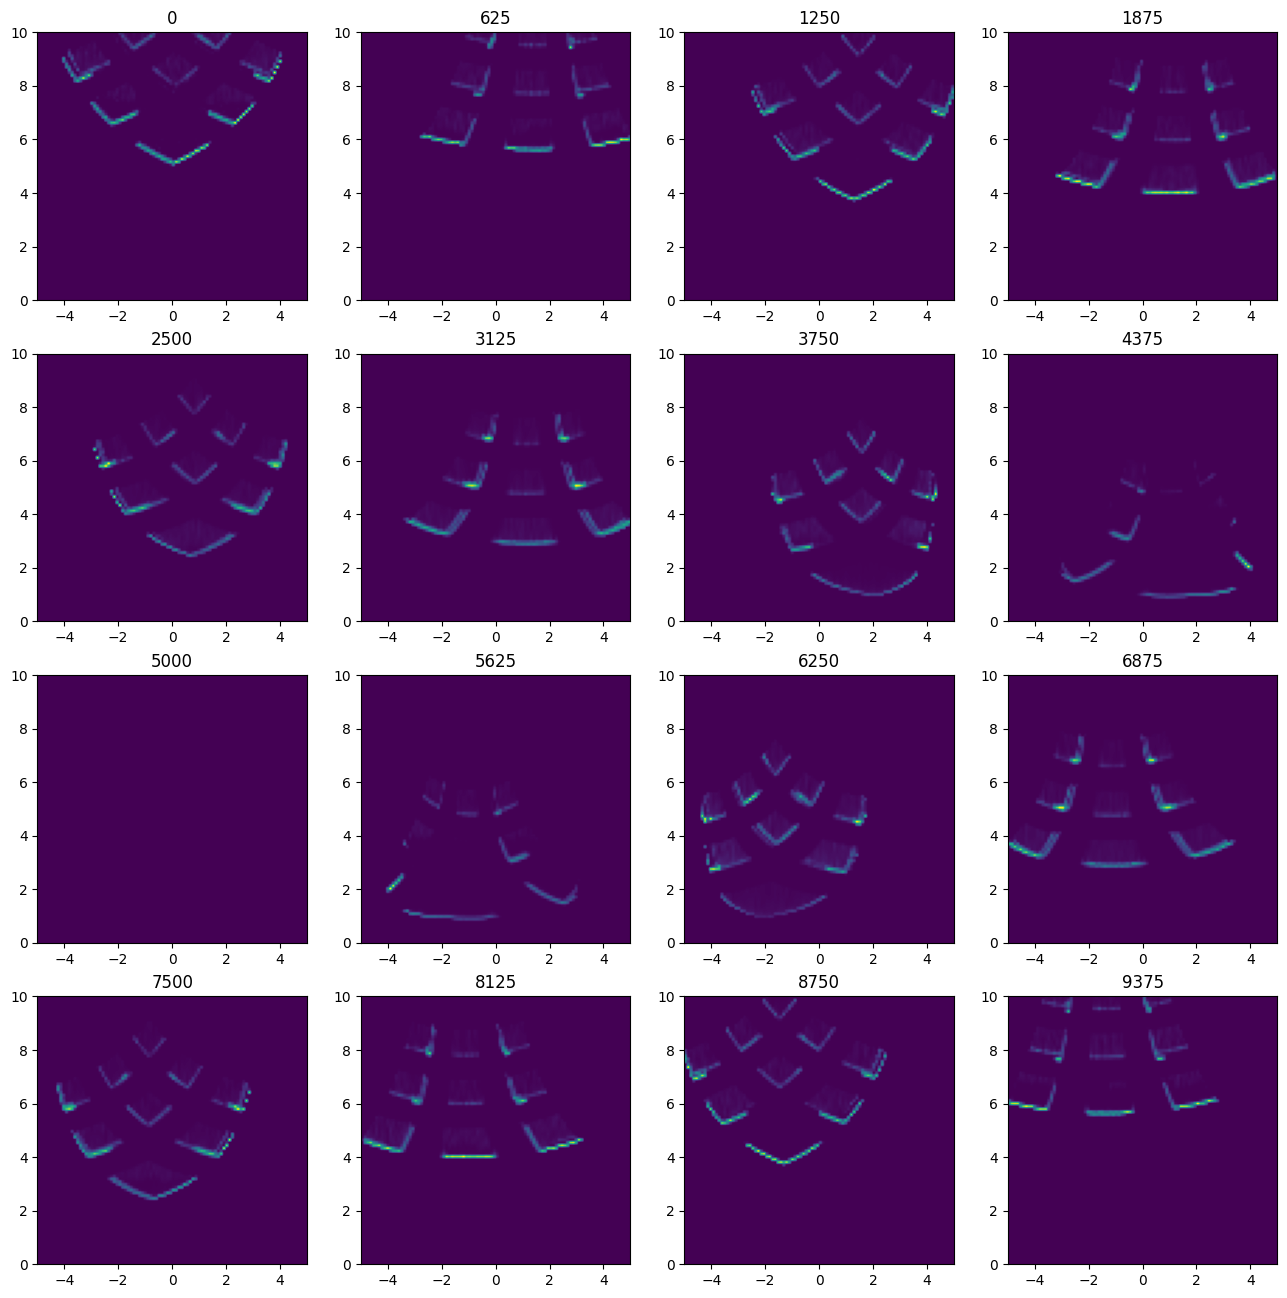

In [2]:
with open("data/sim_96.json") as f:
    cfg = json.load(f)

sensor = VirtualRadar(**cfg)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.reshape(-1)

y = np.load("data/sim_96.npz")
t = (np.arange(axs.shape[0]) * y['y'].shape[0] / axs.shape[0]).astype(int)
for i, ax in zip(t, axs):
    sensor.plot_image(ax, y['y'][i])
    ax.set_title(i)